<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [201]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

import urllib.request
import bs4 as bs
import re

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.utils import pad_sequences

### Datos
Utilizaremos como dataset un escrito sobre inteligencia artificial https://nooscope.ai/.

In [202]:
df = pd.read_csv('Data/nooscope.txt', sep='/n', header=None, engine = 'python')
df.head()

,0
0,The Nooscope is a cartography of the limits of...
1,intended as a provocation to both computer sci...
2,"Any map is a partial perspective, a way to pro..."
3,— of AI dissidents. Its main purpose is to cha...
4,"First, as a technical definition of intelligen..."


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [203]:
# Vistazo a las primeras filas
df.loc[:15,0]

0     The Nooscope is a cartography of the limits of...
1     intended as a provocation to both computer sci...
2     Any map is a partial perspective, a way to pro...
3     — of AI dissidents. Its main purpose is to cha...
4     First, as a technical definition of intelligen...
5     from society and the human. In the expression ...
6     it hints to caricatural ‘alien minds’ that sel...
7     mystifies two processes of proper alienation: ...
8     companies and the invisibilization of workers’...
9     mechanise human reason has clearly mutated, in...
10    into a corporate regime of knowledge extractiv...
11    This is unsurprising, since machine learning a...
12              algorithms for information compression.
13    The purpose of the Nooscope map is to seculari...
14    from the ideological status of ‘intelligent ma...
15    to one of knowledge instrument. Rather than ev...
Name: 0, dtype: object

In [204]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

"The Nooscope is a cartography of the limits of artificial intelligence, intended as a provocation to both computer science and the humanities. Any map is a partial perspective, a way to provoke debate. Similarly, this map is a manifesto — of AI dissidents. Its main purpose is to challenge the mystifications of artificial intelligence. First, as a technical definition of intelligence and, second, as a political form that would be autonomous from society and the human. In the expression ‘artificial intelligence’ the adjective ‘artificial’ carries the myth of the technology’s autonomy: it hints to caricatural ‘alien minds’ that self-reproduce in silico but, actually, mystifies two processes of proper alienation: the growing geopolitical autonomy of hi-tech companies and the invisibilization of workers’ autonomy worldwide. The modern project to mechanise human reason has clearly mutated, in the 21 century, into a corporate regime of knowledge extractivism and epistemic colonialism. This i

In [205]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['the',
 'nooscope',
 'is',
 'a',
 'cartography',
 'of',
 'the',
 'limits',
 'of',
 'artificial',
 'intelligence',
 'intended',
 'as',
 'a',
 'provocation',
 'to',
 'both',
 'computer',
 'science',
 'and']

In [206]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 8610


In [207]:
train_len = 4
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [208]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['the', 'nooscope', 'is', 'a'],
 ['nooscope', 'is', 'a', 'cartography'],
 ['is', 'a', 'cartography', 'of'],
 ['a', 'cartography', 'of', 'the'],
 ['cartography', 'of', 'the', 'limits'],
 ['of', 'the', 'limits', 'of'],
 ['the', 'limits', 'of', 'artificial'],
 ['limits', 'of', 'artificial', 'intelligence'],
 ['of', 'artificial', 'intelligence', 'intended'],
 ['artificial', 'intelligence', 'intended', 'as'],
 ['intelligence', 'intended', 'as', 'a'],
 ['intended', 'as', 'a', 'provocation'],
 ['as', 'a', 'provocation', 'to'],
 ['a', 'provocation', 'to', 'both'],
 ['provocation', 'to', 'both', 'computer'],
 ['to', 'both', 'computer', 'science'],
 ['both', 'computer', 'science', 'and'],
 ['computer', 'science', 'and', 'the'],
 ['science', 'and', 'the', 'humanities'],
 ['and', 'the', 'humanities', 'any']]

In [209]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[1, 70, 5, 3],
 [70, 5, 3, 867],
 [5, 3, 867, 2],
 [3, 867, 2, 1],
 [867, 2, 1, 269],
 [2, 1, 269, 2],
 [1, 269, 2, 77],
 [269, 2, 77, 39],
 [2, 77, 39, 868],
 [77, 39, 868, 11],
 [39, 868, 11, 3],
 [868, 11, 3, 869],
 [11, 3, 869, 6],
 [3, 869, 6, 511],
 [869, 6, 511, 176],
 [6, 511, 176, 107],
 [511, 176, 107, 4],
 [176, 107, 4, 1],
 [107, 4, 1, 512],
 [4, 1, 512, 220]]

In [210]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 8606


## 3. Input y target

In [211]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(8606, 3)
(8606,)


In [212]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'of',
 3: 'a',
 4: 'and',
 5: 'is',
 6: 'to',
 7: 'in',
 8: 'that',
 9: 'machine',
 10: 'learning',
 11: 'as',
 12: 'ai',
 13: 'are',
 14: 'be',
 15: 'for',
 16: 'data',
 17: 'it',
 18: 'by',
 19: 'statistical',
 20: 'an',
 21: 'has',
 22: 'this',
 23: 'not',
 24: 'model',
 25: 'with',
 26: 'which',
 27: 'on',
 28: 'from',
 29: 'can',
 30: 'human',
 31: 'or',
 32: 'its',
 33: 'training',
 34: 'into',
 35: 'recognition',
 36: 'pattern',
 37: 'but',
 38: 'neural',
 39: 'intelligence',
 40: 'algorithms',
 41: 'new',
 42: 'bias',
 43: 'information',
 44: 'one',
 45: 'at',
 46: 'image',
 47: 'algorithm',
 48: 'also',
 49: 'labour',
 50: 'was',
 51: 'have',
 52: 'space',
 53: 'such',
 54: 'what',
 55: 'between',
 56: 'how',
 57: 'dataset',
 58: 'social',
 59: 'networks',
 60: 'network',
 61: 'knowledge',
 62: 'been',
 63: 'logical',
 64: 'models',
 65: 'way',
 66: 'more',
 67: 'through',
 68: 'patterns',
 69: 'these',
 70: 'nooscope',
 71: 'just',
 72: 'visual',
 73: 'does',
 

In [213]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

2244

In [214]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(8606, 2244)

### 4 - Entrenar el modelo

In [215]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [216]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

2244

In [217]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1421 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=4, input_length=input_seq_len))

model.add(LSTM(16, return_sequences=True))
model.add(Dropout(0.3))
model.add(keras.layers.Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.3))
model.add(LSTM(16))
model.add(Dense(16, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_56 (Embedding)    (None, 3, 4)              8980      
                                                                 
 lstm_132 (LSTM)             (None, 3, 16)             1344      
                                                                 
 dropout_74 (Dropout)        (None, 3, 16)             0         
                                                                 
 bidirectional_20 (Bidirecti  (None, 3, 64)            12544     
 onal)                                                           
                                                                 
 dropout_75 (Dropout)        (None, 3, 64)             0         
                                                                 
 lstm_134 (LSTM)             (None, 16)                5184      
                                                     

In [218]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.3)

Epoch 1/50
189/189 [==============================] - 9s 19ms/step - loss: 6.9093 - accuracy: 0.0686 - val_loss: 6.6669 - val_accuracy: 0.0620
Epoch 2/50
189/189 [==============================] - 2s 12ms/step - loss: 6.1969 - accuracy: 0.0692 - val_loss: 6.8296 - val_accuracy: 0.0620
Epoch 3/50
189/189 [==============================] - 2s 12ms/step - loss: 6.1415 - accuracy: 0.0692 - val_loss: 6.9526 - val_accuracy: 0.0620
Epoch 4/50
189/189 [==============================] - 2s 12ms/step - loss: 6.0962 - accuracy: 0.0692 - val_loss: 7.0150 - val_accuracy: 0.0620
Epoch 5/50
189/189 [==============================] - 2s 12ms/step - loss: 6.0661 - accuracy: 0.0679 - val_loss: 7.2712 - val_accuracy: 0.0620
Epoch 6/50
189/189 [==============================] - 2s 12ms/step - loss: 6.0367 - accuracy: 0.0692 - val_loss: 7.3306 - val_accuracy: 0.0620
Epoch 7/50
189/189 [==============================] - 2s 12ms/step - loss: 6.0156 - accuracy: 0.0692 - val_loss: 7.4165 - val_accuracy: 0.0612

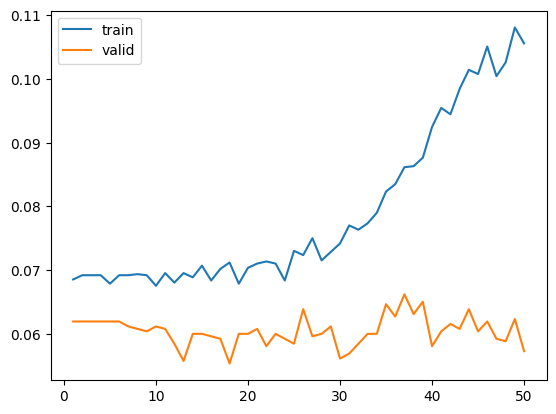

In [219]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [ ]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

In [220]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

D:\FACULTAD\ESPECIALIZACIÓN\4. CUARTO BIMESTRE\NLP\env\lib\site-packages\gradio\deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 21ms/step
Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x17ef9b29910>, 'http://127.0.0.1:7860/', None)

### 6 - Generación de secuencias nuevas

In [223]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [224]:
input_text='the nooscope is'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 19ms/step


'the nooscope is  '

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.